In [1]:
import os
import pandas as pd
import numpy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import imagesize
from torchvision import datasets, models, transforms
import seaborn as sns
from PIL import Image
from PIL.ImageFile import ImageFile
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.profiler import profile, record_function, ProfilerActivity
import optuna
from efficientnet_pytorch import EfficientNet
import torch.nn.functional as F

In [2]:
torch.cuda.empty_cache()

In [3]:
#vars
ImageFile.LOAD_TRUNCATED_IMAGES = True


n_epochs = 15
num_trials = 70
validation_split = .25
images_for_train = 30000
print_every = 100

name_training = "SSWQ_V1_hyperparameters"
os.mkdir(name_training)

In [4]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:

ImageFile.LOAD_TRUNCATED_IMAGES = True
print(device)
print(torch.cuda.get_device_name(5))

cuda:5
NVIDIA RTX A6000


In [5]:
data_path = "data"
#data_path = "D:\Studium\OneDrive - Hochschule Karlsruhe\own-pictures"

image = []
labels = []
width = []
height = []

for file in os.listdir(data_path):
    # if file == 'elektromuell':
    #     for c in os.listdir(os.path.join(data_path, file)):
    #         image.append(c)
    #         labels.append('elektromuell')
    #         w, h = imagesize.get(data_path + "/" + file + "/" + c)
    #         width.append(w), height.append(h)
    if file == 'glas':
        for c in os.listdir(os.path.join(data_path, file)):
            image.append(c)
            labels.append('glas')
            w, h = imagesize.get(data_path + "/" + file + "/" + c)
            width.append(w), height.append(h)
    if file == 'organic':
        for c in os.listdir(os.path.join(data_path, file)):
            image.append(c)
            labels.append('organic')
            w, h = imagesize.get(data_path + "/" + file + "/" + c)
            width.append(w), height.append(h)
    if file == 'paper':
        for c in os.listdir(os.path.join(data_path, file)):
            image.append(c)
            labels.append('paper')
            w, h = imagesize.get(data_path + "/" + file + "/" + c)
            width.append(w), height.append(h)
    if file == 'restmuell':
        for c in os.listdir(os.path.join(data_path, file)):
            image.append(c)
            labels.append('restmuell')
            w, h = imagesize.get(data_path + "/" + file + "/" + c)
            width.append(w), height.append(h)
    if file == 'wertstoff':
        for c in os.listdir(os.path.join(data_path, file)):
            image.append(c)
            labels.append('wertstoff')
            w, h = imagesize.get(data_path + "/" + file + "/" + c)
            width.append(w), height.append(h)

data = {'Images': image, 'labels': labels, 'width': width, 'height': height}
data = pd.DataFrame(data)
lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

In [6]:
data = data.sample(frac=1).reset_index(drop=True)
data = data.head(images_for_train)
tr, val = train_test_split(data, stratify=data.labels, test_size=validation_split)
tr.reset_index(drop=True)
val.reset_index(drop=True)
print(val)

                               Images     labels  width  height  \
14013              organic (6670).jpg    organic    259     194   
8552                organic (165).jpg    organic    269     187   
1712             restmuell (5772).jpg  restmuell    400     533   
17783              organic (6903).jpg    organic    225     225   
9667   150123_dpa_dosen_thumbnail.jpg  wertstoff    768     432   
...                               ...        ...    ...     ...   
8997                 paper (4379).jpg      paper    512     384   
10057                glass (4690).jpg       glas    245     205   
16251              organic (1522).jpg    organic    276     183   
13231                paper (7741).jpg      paper    275     183   
1071                 paper (4528).jpg      paper    512     384   

       encoded_labels  
14013               1  
8552                1  
1712                3  
17783               1  
9667                4  
...               ...  
8997                2  
100

In [7]:
waste_types_df = tr[['encoded_labels', 'labels']].drop_duplicates().sort_values(by='encoded_labels').reset_index(drop=True)
garbage_types = {}
for i in range(0, len(waste_types_df)):
    garbage_types[i] = waste_types_df.iloc[i].labels
print(garbage_types)

{0: 'glas', 1: 'organic', 2: 'paper', 3: 'restmuell', 4: 'wertstoff'}


In [8]:
data

,Images,labels,width,height,encoded_labels
0,organic (6187).jpg,organic,200,253,1
1,plastic467.jpg,wertstoff,4032,3024,4
2,paper (7280).jpg,paper,225,225,2
3,paper (7222).jpg,paper,275,183,2
4,glass (3553).jpg,glas,111,400,0
...,...,...,...,...,...
18744,organic (5723).jpg,organic,275,183,1
18745,restmuell (6011).jpg,restmuell,400,533,3
18746,organic (585).jpg,organic,255,198,1
18747,cardboard165.jpg,paper,3264,2448,2


In [9]:
from torchvision import transforms

transform_tr = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     #transforms.RandomRotation(10),
     transforms.Resize((256,256), interpolation= transforms.InterpolationMode.BICUBIC),
     #transforms.CenterCrop(290),
     #transforms.Resize((300,300), interpolation= transforms.InterpolationMode.BICUBIC),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
transform_val = transforms.Compose(
    [transforms.Resize((256,256), interpolation= transforms.InterpolationMode.BICUBIC),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

In [10]:
from torch.utils.data import Dataset

class GarbageDataset(Dataset):
    def __init__(self, img_data, img_path, transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, index):
        img_name = os.path.join(self.img_path, self.img_data.iloc[index].labels, self.img_data.iloc[index].Images)
        image = Image.open(img_name).convert('RGB')
        #image = image.resize((300, 300))
        label = torch.tensor(self.img_data.iloc[index].encoded_labels)
        if self.transform is not None:
            image = self.transform(image)
        return image, label, img_name

In [11]:
from torch.utils.data import DataLoader

train_dataset = GarbageDataset(tr, data_path, transform_tr)
test_dataset = GarbageDataset(val, data_path, transform_val)


In [12]:
import numpy as np

def img_display(img):
    MEAN = torch.tensor([0.485, 0.456, 0.406])
    STD = torch.tensor([0.229, 0.224, 0.225])

    img = img * STD[:, None, None] + MEAN[:, None, None]
    #img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg


In [13]:
def accuracy(out, labels):
    _, pred = torch.max(out, dim=1)
    return torch.sum(pred == labels).item()

In [14]:
class SSWQ_V1(nn.Module):
    def __init__(self, num_classes, dropout=0.5, hidden_layer1=2048, hidden_layer2=2048):
        super(SSWQ_V1, self).__init__()
        self.dropout = dropout
        self.hidden_layer1 = hidden_layer1
        self.hidden_layer2 = hidden_layer2
        self.num_classes = num_classes

        self.conv0 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, padding=1)

        self.conv1_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv1_3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv1_4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.conv2_3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.conv2_4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(512*7*7, self.hidden_layer1)
        self.fc2 = nn.Linear(self.hidden_layer1, self.hidden_layer2)
        self.fc3 = nn.Linear(self.hidden_layer2, self.num_classes)

    def forward(self, x):
        x = F.relu(self.conv0(x))
        x = self.maxpool(x)
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = F.relu(self.conv1_3(x))
        #x = F.relu(self.conv1_4(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        #x = F.relu(self.conv2_3(x))
        #x = F.relu(self.conv2_4(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        #x = F.relu(self.conv3_3(x))
        #x = F.relu(self.conv3_4(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        #x = F.relu(self.conv4_4(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, self.dropout) #dropout was included to combat overfitting
        x = F.relu(self.fc2(x))
        x = F.dropout(x, self.dropout)
        x = self.fc3(x)
        return x

In [15]:
def get_model(model_name):
    if model_name == "resnet18":
        model = models.resnet18(pretrained=True)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, len(waste_types_df))
    elif model_name == "alexnet":
        model = models.alexnet(pretrained=True)
        in_features = model.classifier[1].in_features
        model.classifier = nn.Linear(in_features, len(waste_types_df))
    elif model_name == "vgg16":
        model = models.vgg16(pretrained=True)
        in_features = model.classifier[0].in_features
        model.classifier = nn.Linear(in_features, len(waste_types_df))
    elif model_name == "resnet50":
        model = models.resnet50(pretrained=True)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, len(waste_types_df))
    elif model_name == "efficientnet_b3":
        model = EfficientNet.from_pretrained("efficientnet-b3",num_classes=len(waste_types_df))
    elif model_name == "efficientnet_b4":
        model = EfficientNet.from_pretrained("efficientnet-b4",num_classes=len(waste_types_df))
    return model


def objective(trial):
    # Hyperparameters we want optimize
    params = {
        #"model_name": trial.suggest_categorical('model_name',["resnet50", "alexnet", "vgg16"]),
        "lr": trial.suggest_loguniform('lr', 1e-4, 1e-2),
        "optimizer_name": trial.suggest_categorical('optimizer_name', ["SGD", "Adam", "Adagrad", "RMSprop"]),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32,64,128]),
        "dropout": trial.suggest_categorical("dropout", [0.3, 0.4, 0.5]),
        "hidden_layer1": trial.suggest_categorical("hidden_layer1", [512, 1024, 2048]),
        "hidden_layer2": trial.suggest_categorical("hidden_layer2", [512, 1024, 2048])
    }
    #For SGD-Optimizer add momentum parameter

    # Get pretrained model
    model = SSWQ_V1(len(waste_types_df), dropout=params["dropout"], hidden_layer1=params["hidden_layer1"], hidden_layer2=params["hidden_layer2"])
    model = model.to(device)

    # Define criterion
    criterion = nn.CrossEntropyLoss()

    # Configure optimizer
    optimizer = getattr(torch.optim, params["optimizer_name"])(model.parameters(), lr=params["lr"])

    if params["optimizer_name"] == "SGD":
        params["momentum"] = trial.suggest_loguniform('momentum', 0.85, 0.95)
        # Configure optimizer again for SGD
        optimizer = getattr(torch.optim, params["optimizer_name"])(model.parameters(), lr=params["lr"],
                                                                   momentum=params["momentum"])

    # Train a model
    best_model, best_loss = train_model(trial, model, criterion, optimizer, num_epochs=n_epochs,
                                        b_size=params["batch_size"])

    # Return accuracy (Objective Value) of the current trial
    return best_loss

In [16]:
CUDA_LAUNCH_BLOCKING=1


def train_model(trial, net, criterion, optimizer, num_epochs, b_size, step_size=7, gamma=0.1): 
    train_dataloader = DataLoader(train_dataset, batch_size=b_size, shuffle=True, num_workers=7, pin_memory=True) 
    test_dataloader = DataLoader(test_dataset, batch_size=b_size, shuffle=True, num_workers=7, pin_memory=True) 
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    val_loss = []
    val_acc = []
    train_loss = []
    train_acc = []
    valid_loss_min = np.Inf
    total_step = len(train_dataloader)

    for epoch in range(1, num_epochs + 1):
        running_loss = 0.0
        correct = 0
        total = 0
        print(f'Epoch {epoch}\n')
        for batch_idx, (data_, target_, _) in enumerate(train_dataloader):
            target_ = target_.type(torch.LongTensor)
            data_, target_ = data_.to(device, non_blocking=True), target_.to(device, non_blocking=True)
            # zero the parameter gradients
            for param in net.parameters():
                param.grad = None
            #optimizer.zero_grad()
            outputs = net(data_)
            loss = criterion(outputs, target_)

            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            _, pred = torch.max(outputs, dim=1)
            correct += torch.sum(pred == target_).item()
            total += target_.size(0)
            #if batch_idx % print_every == 0:
                #print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch, num_epochs, batch_idx, total_step, loss.item()))
        train_acc.append(100 * correct / total)
        train_loss.append(running_loss / total_step)
        print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
        batch_loss = 0
        total_t = 0
        correct_t = 0
        with torch.no_grad():
            net.eval()
            for data_t, target_t, _ in (test_dataloader):
                target_t = target_t.type(torch.LongTensor)
                data_t, target_t = data_t.to(device), target_t.to(device)  # on GPU
                outputs_t = net(data_t)
                loss_t = criterion(outputs_t, target_t)
                batch_loss += loss_t.item()
                _, pred_t = torch.max(outputs_t, dim=1)
                correct_t += torch.sum(pred_t == target_t).item()
                total_t += target_t.size(0)
            val_acc.append(100 * correct_t / total_t)
            val_loss.append(batch_loss / len(test_dataloader))
            network_learned = batch_loss < valid_loss_min
            print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
            # Saving the best weight
            if network_learned:
                valid_loss_min = batch_loss
                torch.save(net.state_dict(), name_training + '/resnet.pt')
                best_model = net
                best_acc = (100 * correct_t / total_t)
                best_loss = np.mean(val_loss)
                print('Detected network improvement, saving current model')

        net.train()
        exp_lr_scheduler.step()

        trial.report(best_loss, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_model, best_loss

In [17]:
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(
    sampler=sampler,
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=2, n_warmup_steps=5, interval_steps=3
    ),
    direction='minimize')
study.optimize(func=objective, n_trials=num_trials)

[I 2022-04-23 13:37:30,755] A new study created in memory with name: no-name-0683a86c-2cda-4bce-9e90-c11dcd3acd55


Epoch 1


train loss: 1.4155, train acc: 36.7826
validation loss: 1.3597, validation acc: 42.5341

Detected network improvement, saving current model
Epoch 2


train loss: 1.3637, train acc: 44.2927
validation loss: 1.3167, validation acc: 46.8857

Detected network improvement, saving current model
Epoch 3


train loss: 1.3304, train acc: 46.9383
validation loss: 1.2913, validation acc: 47.9096

Detected network improvement, saving current model
Epoch 4


train loss: 1.3049, train acc: 49.1003
validation loss: 1.2709, validation acc: 49.9573

Detected network improvement, saving current model
Epoch 5


train loss: 1.2843, train acc: 50.6792
validation loss: 1.2577, validation acc: 51.8345

Detected network improvement, saving current model
Epoch 6


train loss: 1.2662, train acc: 51.7104
validation loss: 1.2413, validation acc: 52.7944

Detected network improvement, saving current model
Epoch 7


train loss: 1.2506, train acc: 52.9194
validation loss: 1.2283, validation acc: 53.2850

D

[I 2022-04-23 14:07:30,100] Trial 0 finished with value: 1.1875227589369315 and parameters: {'lr': 0.00014360886347155054, 'optimizer_name': 'Adagrad', 'batch_size': 64, 'dropout': 0.5, 'hidden_layer1': 512, 'hidden_layer2': 512}. Best is trial 0 with value: 1.1875227589369315.


validation loss: 1.1811, validation acc: 53.4983

Epoch 1


train loss: 1.4242, train acc: 36.0501
validation loss: 1.3192, validation acc: 44.1126

Detected network improvement, saving current model
Epoch 2


train loss: 1.3323, train acc: 47.9411
validation loss: 1.2435, validation acc: 52.7090

Detected network improvement, saving current model
Epoch 3


train loss: 1.2600, train acc: 54.6689
validation loss: 1.1787, validation acc: 57.4872

Detected network improvement, saving current model
Epoch 4


train loss: 1.2040, train acc: 58.9290
validation loss: 1.1379, validation acc: 59.9829

Detected network improvement, saving current model
Epoch 5


train loss: 1.1533, train acc: 63.3739
validation loss: 1.1003, validation acc: 63.6092

Detected network improvement, saving current model
Epoch 6


train loss: 1.1070, train acc: 66.6169
validation loss: 1.0637, validation acc: 66.8089

Detected network improvement, saving current model
Epoch 7


train loss: 1.0646, train acc: 69.2056
v

[I 2022-04-23 14:32:52,842] Trial 1 finished with value: 0.8741761185564437 and parameters: {'lr': 0.0004072322241260537, 'optimizer_name': 'Adam', 'batch_size': 128, 'dropout': 0.4, 'hidden_layer1': 1024, 'hidden_layer2': 2048}. Best is trial 1 with value: 0.8741761185564437.


Detected network improvement, saving current model
Epoch 1


train loss: 10868.0737, train acc: 25.7165
validation loss: 1.5559, validation acc: 27.6877

Detected network improvement, saving current model
Epoch 2


train loss: 5434.7983, train acc: 32.1243
validation loss: 1.5300, validation acc: 35.2389

Detected network improvement, saving current model
Epoch 3


train loss: 3623.6789, train acc: 39.8478
validation loss: 1.4576, validation acc: 45.5845

Detected network improvement, saving current model
Epoch 4


train loss: 2718.0918, train acc: 45.1390
validation loss: 1.4157, validation acc: 47.1843

Detected network improvement, saving current model
Epoch 5


train loss: 2174.7388, train acc: 45.1390
validation loss: 1.3726, validation acc: 52.6877



[I 2022-04-23 14:42:03,526] Trial 2 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.3707, train acc: 40.3314
validation loss: 1.2977, validation acc: 45.9898

Detected network improvement, saving current model
Epoch 2


train loss: 1.3023, train acc: 49.0719
validation loss: 1.2350, validation acc: 52.4104

Detected network improvement, saving current model
Epoch 3


train loss: 1.2475, train acc: 54.0360
validation loss: 1.1832, validation acc: 56.5060

Detected network improvement, saving current model
Epoch 4


train loss: 1.1945, train acc: 59.1708
validation loss: 1.1300, validation acc: 62.2654

Detected network improvement, saving current model
Epoch 5


train loss: 1.1494, train acc: 62.6200
validation loss: 1.0958, validation acc: 63.3106

Detected network improvement, saving current model
Epoch 6


train loss: 1.1083, train acc: 65.3510
validation loss: 1.0670, validation acc: 65.2090

Detected network improvement, saving current model
Epoch 7


train loss: 1.0669, train acc: 68.9922


[I 2022-04-23 15:08:11,368] Trial 3 finished with value: 0.8667308050232965 and parameters: {'lr': 0.0005056727806304022, 'optimizer_name': 'Adam', 'batch_size': 64, 'dropout': 0.5, 'hidden_layer1': 1024, 'hidden_layer2': 1024}. Best is trial 3 with value: 0.8667308050232965.


Detected network improvement, saving current model
Epoch 1


train loss: 1.6061, train acc: 23.2487
validation loss: 1.6010, validation acc: 23.2509

Detected network improvement, saving current model
Epoch 2


train loss: 1.6020, train acc: 23.2558
validation loss: 1.5981, validation acc: 23.2935

Detected network improvement, saving current model
Epoch 3


train loss: 1.5992, train acc: 23.2203
validation loss: 1.5961, validation acc: 24.1254

Detected network improvement, saving current model
Epoch 4


train loss: 1.5971, train acc: 24.2728
validation loss: 1.5947, validation acc: 24.3814

Detected network improvement, saving current model
Epoch 5


train loss: 1.5957, train acc: 24.3297
validation loss: 1.5936, validation acc: 24.2961



[I 2022-04-23 15:18:03,553] Trial 4 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.3669, train acc: 40.1607
validation loss: 1.3177, validation acc: 43.7287

Detected network improvement, saving current model
Epoch 2


train loss: 1.3037, train acc: 47.4433
validation loss: 1.2402, validation acc: 51.7278

Detected network improvement, saving current model
Epoch 3


train loss: 1.2486, train acc: 53.6022
validation loss: 1.2134, validation acc: 52.0265

Detected network improvement, saving current model
Epoch 4


train loss: 1.2092, train acc: 55.9420
validation loss: 1.1740, validation acc: 57.3805

Detected network improvement, saving current model
Epoch 5


train loss: 1.1790, train acc: 57.6346
validation loss: 1.1496, validation acc: 57.9991



[I 2022-04-23 15:27:21,552] Trial 5 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.6049, train acc: 24.0097
validation loss: 1.5892, validation acc: 24.3387

Detected network improvement, saving current model
Epoch 2


train loss: 1.5973, train acc: 23.7252
validation loss: 1.5894, validation acc: 24.3387

Epoch 3


train loss: 1.5946, train acc: 24.0666
validation loss: 1.5892, validation acc: 24.5307

Detected network improvement, saving current model
Epoch 4


train loss: 1.5933, train acc: 24.2017
validation loss: 1.5890, validation acc: 24.3387

Detected network improvement, saving current model
Epoch 5


train loss: 1.5924, train acc: 23.8959


[I 2022-04-23 15:37:03,352] Trial 6 pruned. 


validation loss: 1.5890, validation acc: 24.3387

Epoch 1


train loss: 1.4587, train acc: 35.1184
validation loss: 1.3047, validation acc: 44.1126

Detected network improvement, saving current model
Epoch 2


train loss: 1.3628, train acc: 46.3836
validation loss: 1.2494, validation acc: 51.1945

Detected network improvement, saving current model
Epoch 3


train loss: 1.3004, train acc: 52.4358
validation loss: 1.2100, validation acc: 53.5836

Detected network improvement, saving current model
Epoch 4


train loss: 1.2507, train acc: 55.4370
validation loss: 1.1823, validation acc: 55.7167

Detected network improvement, saving current model
Epoch 5


train loss: 1.2143, train acc: 57.4639
validation loss: 1.1636, validation acc: 57.1886



[I 2022-04-23 15:45:11,467] Trial 7 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.6100, train acc: 21.3569
validation loss: 1.6067, validation acc: 24.3387

Detected network improvement, saving current model
Epoch 2


train loss: 1.6073, train acc: 24.3368
validation loss: 1.6045, validation acc: 24.3387

Detected network improvement, saving current model
Epoch 3


train loss: 1.6050, train acc: 24.3439
validation loss: 1.6026, validation acc: 24.3387

Detected network improvement, saving current model
Epoch 4


train loss: 1.6031, train acc: 24.3368
validation loss: 1.6010, validation acc: 24.3387

Detected network improvement, saving current model
Epoch 5


train loss: 1.6015, train acc: 24.3439
validation loss: 1.5997, validation acc: 24.3387



[I 2022-04-23 15:54:24,849] Trial 8 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.5915, train acc: 24.1164
validation loss: 1.5881, validation acc: 24.3387

Detected network improvement, saving current model
Epoch 2


train loss: 1.5900, train acc: 24.2728
validation loss: 1.5881, validation acc: 24.3387

Detected network improvement, saving current model
Epoch 3


train loss: 1.5895, train acc: 24.1661
validation loss: 1.5881, validation acc: 24.3387

Epoch 4


train loss: 1.5892, train acc: 24.1875
validation loss: 1.5883, validation acc: 23.7415

Epoch 5


train loss: 1.5890, train acc: 24.2088


[I 2022-04-23 16:03:35,363] Trial 9 pruned. 


validation loss: 1.5883, validation acc: 24.3387

Epoch 1


train loss: 1.6538, train acc: 23.6185
validation loss: 1.5893, validation acc: 22.9735

Detected network improvement, saving current model
Epoch 2


train loss: 1.6215, train acc: 24.1519
validation loss: 1.5888, validation acc: 24.2747

Detected network improvement, saving current model
Epoch 3


train loss: 1.6108, train acc: 23.8461
validation loss: 1.5882, validation acc: 23.8908

Detected network improvement, saving current model
Epoch 4


train loss: 1.6053, train acc: 24.3226
validation loss: 1.5882, validation acc: 24.3387

Epoch 5


train loss: 1.6020, train acc: 24.1164


[I 2022-04-23 16:12:32,924] Trial 10 pruned. 


validation loss: 1.5883, validation acc: 24.3601

Epoch 1


train loss: 1.4856, train acc: 33.3191
validation loss: 1.3074, validation acc: 44.0700

Detected network improvement, saving current model
Epoch 2


train loss: 1.3876, train acc: 45.7222
validation loss: 1.2737, validation acc: 48.2509

Detected network improvement, saving current model
Epoch 3


train loss: 1.3220, train acc: 51.2837
validation loss: 1.2407, validation acc: 52.9863

Detected network improvement, saving current model
Epoch 4


train loss: 1.2644, train acc: 56.6105
validation loss: 1.1857, validation acc: 59.9829

Detected network improvement, saving current model
Epoch 5


train loss: 1.2103, train acc: 61.2474
validation loss: 1.1439, validation acc: 63.0333



[I 2022-04-23 16:21:00,007] Trial 11 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.4630, train acc: 33.4969
validation loss: 1.3177, validation acc: 42.8968

Detected network improvement, saving current model
Epoch 2


train loss: 1.3791, train acc: 44.9684
validation loss: 1.2684, validation acc: 48.2722

Detected network improvement, saving current model
Epoch 3


train loss: 1.3146, train acc: 50.9850
validation loss: 1.2347, validation acc: 54.4155

Detected network improvement, saving current model
Epoch 4


train loss: 1.2586, train acc: 55.3872
validation loss: 1.1797, validation acc: 59.9189

Detected network improvement, saving current model
Epoch 5


train loss: 1.2064, train acc: 60.5433
validation loss: 1.1358, validation acc: 62.1800



[I 2022-04-23 16:29:30,200] Trial 12 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.4635, train acc: 34.5850
validation loss: 1.2570, validation acc: 47.4616

Detected network improvement, saving current model
Epoch 2


train loss: 1.3637, train acc: 47.1588
validation loss: 1.2101, validation acc: 52.8584

Detected network improvement, saving current model
Epoch 3


train loss: 1.2851, train acc: 55.3588
validation loss: 1.1814, validation acc: 55.2901

Detected network improvement, saving current model
Epoch 4


train loss: 1.2284, train acc: 58.3316
validation loss: 1.1346, validation acc: 61.1561

Detected network improvement, saving current model
Epoch 5


train loss: 1.1836, train acc: 60.9416


[I 2022-04-23 16:38:06,875] Trial 13 pruned. 


validation loss: 1.1095, validation acc: 60.7722

Epoch 1


train loss: 18004510069317806.0000, train acc: 22.1606
validation loss: 88067493.4054, validation acc: 18.2381

Detected network improvement, saving current model
Epoch 2


train loss: 9002255035199333.0000, train acc: 21.1151
validation loss: 44035476.0309, validation acc: 23.2722

Detected network improvement, saving current model
Epoch 3


train loss: 6001503356800034.0000, train acc: 20.9302
validation loss: 29357149.6657, validation acc: 19.9872

Detected network improvement, saving current model
Epoch 4


train loss: 4501127517600082.5000, train acc: 21.2645
validation loss: 22017890.1129, validation acc: 22.8242

Detected network improvement, saving current model
Epoch 5


train loss: 3600902014080077.5000, train acc: 23.5687
validation loss: 17614324.0939, validation acc: 23.8055



[I 2022-04-23 16:46:39,886] Trial 14 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.3919, train acc: 38.7170
validation loss: 1.2579, validation acc: 47.1843

Detected network improvement, saving current model
Epoch 2


train loss: 1.2936, train acc: 50.3449
validation loss: 1.2049, validation acc: 52.6877

Detected network improvement, saving current model
Epoch 3


train loss: 1.2192, train acc: 56.9945
validation loss: 1.1353, validation acc: 59.8763

Detected network improvement, saving current model
Epoch 4


train loss: 1.1580, train acc: 61.7879
validation loss: 1.0891, validation acc: 64.9531

Detected network improvement, saving current model
Epoch 5


train loss: 1.1035, train acc: 66.1475
validation loss: 1.0542, validation acc: 64.1852

Detected network improvement, saving current model
Epoch 6


train loss: 1.0587, train acc: 68.6935
validation loss: 1.0194, validation acc: 68.6007

Detected network improvement, saving current model
Epoch 7


train loss: 1.0181, train acc: 71.4032


[I 2022-04-23 17:13:30,589] Trial 15 finished with value: 0.831745914269138 and parameters: {'lr': 0.00013137286120003966, 'optimizer_name': 'Adam', 'batch_size': 64, 'dropout': 0.4, 'hidden_layer1': 512, 'hidden_layer2': 2048}. Best is trial 15 with value: 0.831745914269138.


Detected network improvement, saving current model
Epoch 1


train loss: 1.4169, train acc: 37.6645
validation loss: 1.3366, validation acc: 43.8567

Detected network improvement, saving current model
Epoch 2


train loss: 1.3347, train acc: 47.1446
validation loss: 1.2421, validation acc: 52.8797

Detected network improvement, saving current model
Epoch 3


train loss: 1.2625, train acc: 54.9534
validation loss: 1.1826, validation acc: 57.2526

Detected network improvement, saving current model
Epoch 4


train loss: 1.2039, train acc: 59.3130
validation loss: 1.1406, validation acc: 60.1962

Detected network improvement, saving current model
Epoch 5


train loss: 1.1529, train acc: 63.3810
validation loss: 1.0929, validation acc: 64.3985

Detected network improvement, saving current model
Epoch 6


train loss: 1.1088, train acc: 65.8701
validation loss: 1.0515, validation acc: 68.3234

Detected network improvement, saving current model
Epoch 7


train loss: 1.0688, train acc: 68.9211


[I 2022-04-23 17:41:53,821] Trial 16 finished with value: 0.856947827553964 and parameters: {'lr': 0.00011574032229868549, 'optimizer_name': 'Adam', 'batch_size': 64, 'dropout': 0.5, 'hidden_layer1': 512, 'hidden_layer2': 1024}. Best is trial 15 with value: 0.831745914269138.


Detected network improvement, saving current model
Epoch 1


train loss: 1.3958, train acc: 38.5890
validation loss: 1.2999, validation acc: 43.6007

Detected network improvement, saving current model
Epoch 2


train loss: 1.3248, train acc: 46.9739
validation loss: 1.2814, validation acc: 49.6800

Detected network improvement, saving current model
Epoch 3


train loss: 1.2666, train acc: 53.5168
validation loss: 1.2193, validation acc: 56.0367

Detected network improvement, saving current model
Epoch 4


train loss: 1.2137, train acc: 57.6133
validation loss: 1.1737, validation acc: 58.4258

Detected network improvement, saving current model
Epoch 5


train loss: 1.1657, train acc: 62.0368
validation loss: 1.1363, validation acc: 61.9667



[I 2022-04-23 17:52:17,584] Trial 17 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.4661, train acc: 39.5847
validation loss: 1.2809, validation acc: 45.9044

Detected network improvement, saving current model
Epoch 2


train loss: 1.3510, train acc: 49.4488
validation loss: 1.1999, validation acc: 54.1596

Detected network improvement, saving current model
Epoch 3


train loss: 1.2702, train acc: 55.7926
validation loss: 1.2049, validation acc: 52.3891

Epoch 4


train loss: 1.2075, train acc: 60.3798
validation loss: 1.1494, validation acc: 61.9454

Detected network improvement, saving current model
Epoch 5


train loss: 1.1551, train acc: 63.4663
validation loss: 1.1117, validation acc: 63.5666



[I 2022-04-23 18:02:20,944] Trial 18 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.3962, train acc: 38.1552
validation loss: 1.2928, validation acc: 45.3712

Detected network improvement, saving current model
Epoch 2


train loss: 1.3161, train acc: 47.3010
validation loss: 1.2517, validation acc: 50.8532

Detected network improvement, saving current model
Epoch 3


train loss: 1.2525, train acc: 54.6547
validation loss: 1.1983, validation acc: 55.9727

Detected network improvement, saving current model
Epoch 4


train loss: 1.2018, train acc: 57.9120
validation loss: 1.1530, validation acc: 59.1084

Detected network improvement, saving current model
Epoch 5


train loss: 1.1553, train acc: 62.0866
validation loss: 1.1128, validation acc: 61.6468



[I 2022-04-23 18:12:28,738] Trial 19 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.3583, train acc: 41.3769
validation loss: 1.2073, validation acc: 51.1305

Detected network improvement, saving current model
Epoch 2


train loss: 1.2654, train acc: 51.7104
validation loss: 1.1496, validation acc: 55.0768

Detected network improvement, saving current model
Epoch 3


train loss: 1.1947, train acc: 57.7768
validation loss: 1.0997, validation acc: 59.1724

Detected network improvement, saving current model
Epoch 4


train loss: 1.1346, train acc: 63.3952
validation loss: 1.0612, validation acc: 63.8865

Detected network improvement, saving current model
Epoch 5


train loss: 1.0831, train acc: 66.6738
validation loss: 1.0155, validation acc: 68.8353

Detected network improvement, saving current model
Epoch 6


train loss: 1.0354, train acc: 69.8812
validation loss: 0.9815, validation acc: 70.3498

Detected network improvement, saving current model
Epoch 7


train loss: 0.9923, train acc: 72.9536


[I 2022-04-23 18:44:20,326] Trial 20 finished with value: 0.7790094548406183 and parameters: {'lr': 0.0001979980249771655, 'optimizer_name': 'Adam', 'batch_size': 16, 'dropout': 0.5, 'hidden_layer1': 512, 'hidden_layer2': 2048}. Best is trial 20 with value: 0.7790094548406183.


Detected network improvement, saving current model
Epoch 1


train loss: 1.3595, train acc: 42.1236
validation loss: 1.2211, validation acc: 48.9334

Detected network improvement, saving current model
Epoch 2


train loss: 1.2688, train acc: 51.9238
validation loss: 1.1432, validation acc: 57.4445

Detected network improvement, saving current model
Epoch 3


train loss: 1.1893, train acc: 59.5975
validation loss: 1.0877, validation acc: 61.3908

Detected network improvement, saving current model
Epoch 4


train loss: 1.1284, train acc: 63.5303
validation loss: 1.0533, validation acc: 63.9078

Detected network improvement, saving current model
Epoch 5


train loss: 1.0771, train acc: 67.0009
validation loss: 1.0118, validation acc: 68.4940

Detected network improvement, saving current model
Epoch 6


train loss: 1.0319, train acc: 69.4474
validation loss: 0.9792, validation acc: 69.9659

Detected network improvement, saving current model
Epoch 7


train loss: 0.9908, train acc: 72.2353


[I 2022-04-23 19:16:28,072] Trial 21 finished with value: 0.7948399548458023 and parameters: {'lr': 0.00019208420988903844, 'optimizer_name': 'Adam', 'batch_size': 16, 'dropout': 0.5, 'hidden_layer1': 512, 'hidden_layer2': 2048}. Best is trial 20 with value: 0.7790094548406183.


Detected network improvement, saving current model
Epoch 1


train loss: 1.3584, train acc: 42.0383
validation loss: 1.2233, validation acc: 49.2961

Detected network improvement, saving current model
Epoch 2


train loss: 1.2547, train acc: 53.1612
validation loss: 1.1601, validation acc: 55.7167

Detected network improvement, saving current model
Epoch 3


train loss: 1.1802, train acc: 58.8436
validation loss: 1.1065, validation acc: 60.7722

Detected network improvement, saving current model
Epoch 4


train loss: 1.1213, train acc: 63.5446
validation loss: 1.0556, validation acc: 65.5930

Detected network improvement, saving current model
Epoch 5


train loss: 1.0734, train acc: 65.9484
validation loss: 1.0209, validation acc: 66.1903

Detected network improvement, saving current model
Epoch 6


train loss: 1.0305, train acc: 69.0918
validation loss: 0.9893, validation acc: 69.2619

Detected network improvement, saving current model
Epoch 7


train loss: 0.9909, train acc: 71.6308


[I 2022-04-23 19:46:08,497] Trial 22 finished with value: 0.811954506043349 and parameters: {'lr': 0.0002064864316380501, 'optimizer_name': 'Adam', 'batch_size': 16, 'dropout': 0.5, 'hidden_layer1': 512, 'hidden_layer2': 2048}. Best is trial 20 with value: 0.7790094548406183.


Detected network improvement, saving current model
Epoch 1


train loss: 1.3720, train acc: 40.9075
validation loss: 1.3544, validation acc: 47.4403

Detected network improvement, saving current model
Epoch 2


train loss: 1.2901, train acc: 50.4943
validation loss: 1.2439, validation acc: 53.2637

Detected network improvement, saving current model
Epoch 3


train loss: 1.2220, train acc: 56.6389
validation loss: 1.1629, validation acc: 60.8148

Detected network improvement, saving current model
Epoch 4


train loss: 1.1607, train acc: 61.9017
validation loss: 1.1061, validation acc: 63.9718

Detected network improvement, saving current model
Epoch 5


train loss: 1.1109, train acc: 65.0167
validation loss: 1.0628, validation acc: 66.0196

Detected network improvement, saving current model
Epoch 6


train loss: 1.0657, train acc: 68.2099
validation loss: 1.0185, validation acc: 70.7765

Detected network improvement, saving current model
Epoch 7


train loss: 1.0241, train acc: 71.2183


[I 2022-04-23 20:14:05,578] Trial 23 finished with value: 0.8117357943838504 and parameters: {'lr': 0.00020594471523198405, 'optimizer_name': 'Adam', 'batch_size': 16, 'dropout': 0.5, 'hidden_layer1': 512, 'hidden_layer2': 2048}. Best is trial 20 with value: 0.7790094548406183.


Detected network improvement, saving current model
Epoch 1


train loss: 1.3542, train acc: 42.4863
validation loss: 1.2626, validation acc: 46.8217

Detected network improvement, saving current model
Epoch 2


train loss: 1.2716, train acc: 51.4615
validation loss: 1.1943, validation acc: 53.7116

Detected network improvement, saving current model
Epoch 3


train loss: 1.2062, train acc: 57.1225
validation loss: 1.1317, validation acc: 60.0683

Detected network improvement, saving current model
Epoch 4


train loss: 1.1508, train acc: 62.1435
validation loss: 1.0846, validation acc: 62.9693

Detected network improvement, saving current model
Epoch 5


train loss: 1.0999, train acc: 65.9626
validation loss: 1.0494, validation acc: 64.3131

Detected network improvement, saving current model
Epoch 6


train loss: 1.0545, train acc: 68.5015
validation loss: 1.0168, validation acc: 67.8541

Detected network improvement, saving current model
Epoch 7


train loss: 1.0134, train acc: 71.3392


[I 2022-04-23 20:43:38,781] Trial 24 finished with value: 0.8064336969439826 and parameters: {'lr': 0.0003118915138743869, 'optimizer_name': 'Adam', 'batch_size': 16, 'dropout': 0.5, 'hidden_layer1': 512, 'hidden_layer2': 2048}. Best is trial 20 with value: 0.7790094548406183.


Detected network improvement, saving current model
Epoch 1


train loss: 1.4021, train acc: 38.9233
validation loss: 1.2624, validation acc: 47.7389

Detected network improvement, saving current model
Epoch 2


train loss: 1.3181, train acc: 49.4773
validation loss: 1.2014, validation acc: 53.7969

Detected network improvement, saving current model
Epoch 3


train loss: 1.2598, train acc: 53.9649
validation loss: 1.1608, validation acc: 56.6980

Detected network improvement, saving current model
Epoch 4


train loss: 1.2066, train acc: 58.7227
validation loss: 1.1220, validation acc: 60.7722

Detected network improvement, saving current model
Epoch 5


train loss: 1.1607, train acc: 62.1293
validation loss: 1.0984, validation acc: 59.2363



[I 2022-04-23 20:53:32,015] Trial 25 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.6726, train acc: 32.7146
validation loss: 1.2459, validation acc: 47.7816

Detected network improvement, saving current model
Epoch 2


train loss: 1.4431, train acc: 51.3050
validation loss: 1.2369, validation acc: 53.2637

Detected network improvement, saving current model
Epoch 3


train loss: 1.3198, train acc: 57.9333
validation loss: 1.2092, validation acc: 54.9701

Detected network improvement, saving current model
Epoch 4


train loss: 1.2394, train acc: 61.4608
validation loss: 1.1521, validation acc: 61.0922

Detected network improvement, saving current model
Epoch 5


train loss: 1.1776, train acc: 64.1277
validation loss: 1.1011, validation acc: 65.8063



[I 2022-04-23 21:03:26,036] Trial 26 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.5914, train acc: 24.0950
validation loss: 1.5888, validation acc: 24.3174

Detected network improvement, saving current model
Epoch 2


train loss: 1.5900, train acc: 24.2230
validation loss: 1.5885, validation acc: 24.3387

Detected network improvement, saving current model
Epoch 3


train loss: 1.5895, train acc: 24.1448
validation loss: 1.5884, validation acc: 24.3174

Epoch 4


train loss: 1.5893, train acc: 24.1661
validation loss: 1.5883, validation acc: 23.8481

Epoch 5


train loss: 1.5891, train acc: 23.8674


[I 2022-04-23 21:13:00,611] Trial 27 pruned. 


validation loss: 1.5883, validation acc: 24.3387

Epoch 1


train loss: 1.3763, train acc: 39.0655
validation loss: 1.3132, validation acc: 42.5981

Detected network improvement, saving current model
Epoch 2


train loss: 1.3395, train acc: 43.7024
validation loss: 1.3023, validation acc: 44.8166

Detected network improvement, saving current model
Epoch 3


train loss: 1.3108, train acc: 47.1517
validation loss: 1.2820, validation acc: 47.8669

Detected network improvement, saving current model
Epoch 4


train loss: 1.2852, train acc: 49.7546
validation loss: 1.2540, validation acc: 51.7065

Detected network improvement, saving current model
Epoch 5


train loss: 1.2621, train acc: 52.0944
validation loss: 1.2331, validation acc: 52.6877



[I 2022-04-23 21:21:50,915] Trial 28 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.4077, train acc: 37.6076
validation loss: 1.3377, validation acc: 42.2568

Detected network improvement, saving current model
Epoch 2


train loss: 1.3690, train acc: 43.2900
validation loss: 1.3182, validation acc: 44.7739

Detected network improvement, saving current model
Epoch 3


train loss: 1.3444, train acc: 45.1604
validation loss: 1.3012, validation acc: 47.3549

Detected network improvement, saving current model
Epoch 4


train loss: 1.3223, train acc: 47.8771
validation loss: 1.2831, validation acc: 49.3814

Detected network improvement, saving current model
Epoch 5


train loss: 1.3014, train acc: 50.0249
validation loss: 1.2670, validation acc: 50.4053



[I 2022-04-23 21:30:50,114] Trial 29 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.3519, train acc: 42.2658
validation loss: 1.2174, validation acc: 50.4906

Detected network improvement, saving current model
Epoch 2


train loss: 1.2507, train acc: 54.2209
validation loss: 1.1707, validation acc: 56.1220

Detected network improvement, saving current model
Epoch 3


train loss: 1.1820, train acc: 58.3813
validation loss: 1.1322, validation acc: 58.8737

Detected network improvement, saving current model
Epoch 4


train loss: 1.1232, train acc: 63.5446
validation loss: 1.0751, validation acc: 65.1237

Detected network improvement, saving current model
Epoch 5


train loss: 1.0688, train acc: 67.7619


[I 2022-04-23 21:39:50,394] Trial 30 pruned. 


validation loss: 1.0630, validation acc: 63.0759

Epoch 1


train loss: 1.3627, train acc: 41.9814
validation loss: 1.2281, validation acc: 49.1041

Detected network improvement, saving current model
Epoch 2


train loss: 1.2619, train acc: 53.4244
validation loss: 1.1848, validation acc: 54.8635

Detected network improvement, saving current model
Epoch 3


train loss: 1.1948, train acc: 57.8906
validation loss: 1.1262, validation acc: 58.7671

Detected network improvement, saving current model
Epoch 4


train loss: 1.1387, train acc: 62.4138
validation loss: 1.0857, validation acc: 63.2679

Detected network improvement, saving current model
Epoch 5


train loss: 1.0898, train acc: 66.2186
validation loss: 1.0452, validation acc: 66.2756

Detected network improvement, saving current model
Epoch 6


train loss: 1.0450, train acc: 68.8998
validation loss: 1.0130, validation acc: 67.4915

Detected network improvement, saving current model
Epoch 7


train loss: 1.0050, train acc: 71.1614
v

[I 2022-04-23 22:06:31,889] Trial 31 finished with value: 0.8131349506926756 and parameters: {'lr': 0.0002259777459470045, 'optimizer_name': 'Adam', 'batch_size': 16, 'dropout': 0.5, 'hidden_layer1': 512, 'hidden_layer2': 2048}. Best is trial 20 with value: 0.7790094548406183.


Detected network improvement, saving current model
Epoch 1


train loss: 1.4250, train acc: 37.4867
validation loss: 1.3276, validation acc: 44.0913

Detected network improvement, saving current model
Epoch 2


train loss: 1.3448, train acc: 47.5571
validation loss: 1.2447, validation acc: 52.6877

Detected network improvement, saving current model
Epoch 3


train loss: 1.2762, train acc: 53.3888
validation loss: 1.1863, validation acc: 55.9727

Detected network improvement, saving current model
Epoch 4


train loss: 1.2233, train acc: 58.2462
validation loss: 1.1402, validation acc: 60.5802

Detected network improvement, saving current model
Epoch 5


train loss: 1.1737, train acc: 62.2075
validation loss: 1.1015, validation acc: 64.1212



[I 2022-04-23 22:15:35,771] Trial 32 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.3214, train acc: 43.8731
validation loss: 1.2044, validation acc: 51.1519

Detected network improvement, saving current model
Epoch 2


train loss: 1.2376, train acc: 53.3035
validation loss: 1.1189, validation acc: 59.1937

Detected network improvement, saving current model
Epoch 3


train loss: 1.1575, train acc: 61.2688
validation loss: 1.0620, validation acc: 62.8200

Detected network improvement, saving current model
Epoch 4


train loss: 1.0988, train acc: 64.0424
validation loss: 1.0336, validation acc: 63.1613

Detected network improvement, saving current model
Epoch 5


train loss: 1.0495, train acc: 67.3707
validation loss: 0.9880, validation acc: 69.0273

Detected network improvement, saving current model
Epoch 6


train loss: 1.0067, train acc: 70.2013
validation loss: 0.9599, validation acc: 68.8993

Epoch 7


train loss: 0.9662, train acc: 73.1811
validation loss: 0.9307, validation acc: 71.8643

D

[I 2022-04-23 22:42:15,591] Trial 33 finished with value: 0.7688507913000484 and parameters: {'lr': 0.00016293171454852539, 'optimizer_name': 'Adam', 'batch_size': 16, 'dropout': 0.5, 'hidden_layer1': 512, 'hidden_layer2': 2048}. Best is trial 33 with value: 0.7688507913000484.


Detected network improvement, saving current model
Epoch 1


train loss: 1.3561, train acc: 42.1094
validation loss: 1.2194, validation acc: 50.5759

Detected network improvement, saving current model
Epoch 2


train loss: 1.2546, train acc: 53.8084
validation loss: 1.1959, validation acc: 54.2022

Detected network improvement, saving current model
Epoch 3


train loss: 1.1809, train acc: 59.3841
validation loss: 1.1506, validation acc: 58.3404

Detected network improvement, saving current model
Epoch 4


train loss: 1.1240, train acc: 63.0041
validation loss: 1.0974, validation acc: 63.8865

Detected network improvement, saving current model
Epoch 5


train loss: 1.0783, train acc: 65.1590
validation loss: 1.0490, validation acc: 66.9795

Detected network improvement, saving current model
Epoch 6


train loss: 1.0361, train acc: 68.5442
validation loss: 1.0142, validation acc: 67.3208

Detected network improvement, saving current model
Epoch 7


train loss: 0.9943, train acc: 71.8726


[I 2022-04-23 23:09:05,294] Trial 34 finished with value: 0.8208406475086086 and parameters: {'lr': 0.00016297550533067774, 'optimizer_name': 'Adam', 'batch_size': 16, 'dropout': 0.5, 'hidden_layer1': 512, 'hidden_layer2': 2048}. Best is trial 33 with value: 0.7688507913000484.


validation loss: 0.8079, validation acc: 78.1783

Epoch 1


train loss: 1.3720, train acc: 40.4310
validation loss: 1.2401, validation acc: 48.2722

Detected network improvement, saving current model
Epoch 2


train loss: 1.2764, train acc: 51.9878
validation loss: 1.1571, validation acc: 56.2287

Detected network improvement, saving current model
Epoch 3


train loss: 1.2063, train acc: 57.2577
validation loss: 1.1147, validation acc: 57.6792

Detected network improvement, saving current model
Epoch 4


train loss: 1.1455, train acc: 62.5418
validation loss: 1.0682, validation acc: 64.9957

Detected network improvement, saving current model
Epoch 5


train loss: 1.0956, train acc: 65.7492
validation loss: 1.0259, validation acc: 67.0435

Detected network improvement, saving current model
Epoch 6


train loss: 1.0528, train acc: 67.9753
validation loss: 0.9901, validation acc: 70.2005

Detected network improvement, saving current model
Epoch 7


train loss: 1.0123, train acc: 71.1827
v

[I 2022-04-23 23:34:48,281] Trial 35 finished with value: 0.8152214675287347 and parameters: {'lr': 0.00014769847418800037, 'optimizer_name': 'Adam', 'batch_size': 32, 'dropout': 0.5, 'hidden_layer1': 512, 'hidden_layer2': 2048}. Best is trial 33 with value: 0.7688507913000484.


validation loss: 0.8037, validation acc: 78.0290

Epoch 1


train loss: 1.4479, train acc: 34.7842
validation loss: 1.3273, validation acc: 43.6007

Detected network improvement, saving current model
Epoch 2


train loss: 1.3561, train acc: 47.2442
validation loss: 1.2276, validation acc: 54.8848

Detected network improvement, saving current model
Epoch 3


train loss: 1.2779, train acc: 55.0388
validation loss: 1.1815, validation acc: 57.8712

Detected network improvement, saving current model
Epoch 4


train loss: 1.2122, train acc: 60.1380
validation loss: 1.1369, validation acc: 61.1348

Detected network improvement, saving current model
Epoch 5


train loss: 1.1605, train acc: 62.7551
validation loss: 1.0980, validation acc: 63.4172



[I 2022-04-23 23:43:40,874] Trial 36 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 105.2040, train acc: 32.3377
validation loss: 1.3134, validation acc: 43.8353

Detected network improvement, saving current model
Epoch 2


train loss: 53.3084, train acc: 40.1821
validation loss: 1.3239, validation acc: 43.3234

Epoch 3


train loss: 35.9705, train acc: 46.6610
validation loss: 1.3725, validation acc: 39.6331

Epoch 4


train loss: 27.2760, train acc: 51.5113
validation loss: 1.3595, validation acc: 46.8643

Epoch 5


train loss: 22.0452, train acc: 54.7756
validation loss: 1.2971, validation acc: 57.9352



[I 2022-04-23 23:52:34,083] Trial 37 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.3706, train acc: 41.0995
validation loss: 1.2460, validation acc: 46.9283

Detected network improvement, saving current model
Epoch 2


train loss: 1.2987, train acc: 49.4062
validation loss: 1.2006, validation acc: 51.6638

Detected network improvement, saving current model
Epoch 3


train loss: 1.2314, train acc: 56.5394
validation loss: 1.1549, validation acc: 56.8046

Detected network improvement, saving current model
Epoch 4


train loss: 1.1761, train acc: 60.1735
validation loss: 1.1034, validation acc: 62.2227

Detected network improvement, saving current model
Epoch 5


train loss: 1.1255, train acc: 64.0779
validation loss: 1.0673, validation acc: 65.4650



[I 2022-04-24 00:01:23,900] Trial 38 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.5928, train acc: 24.0026
validation loss: 1.5886, validation acc: 24.2108

Detected network improvement, saving current model
Epoch 2


train loss: 1.5906, train acc: 24.2586
validation loss: 1.5883, validation acc: 24.3387

Detected network improvement, saving current model
Epoch 3


train loss: 1.5898, train acc: 24.3226
validation loss: 1.5883, validation acc: 24.3814

Epoch 4


train loss: 1.5894, train acc: 24.4008
validation loss: 1.5883, validation acc: 24.2534

Epoch 5


train loss: 1.5892, train acc: 24.3510


[I 2022-04-24 00:09:42,857] Trial 39 pruned. 


validation loss: 1.5883, validation acc: 24.3174

Epoch 1


train loss: 1.3322, train acc: 42.5574
validation loss: 1.2155, validation acc: 49.5520

Detected network improvement, saving current model
Epoch 2


train loss: 1.2393, train acc: 53.4670
validation loss: 1.1398, validation acc: 57.7005

Detected network improvement, saving current model
Epoch 3


train loss: 1.1741, train acc: 58.8365
validation loss: 1.0898, validation acc: 60.6655

Detected network improvement, saving current model
Epoch 4


train loss: 1.1243, train acc: 61.9586
validation loss: 1.0535, validation acc: 63.7159

Detected network improvement, saving current model
Epoch 5


train loss: 1.0856, train acc: 63.9286
validation loss: 1.0296, validation acc: 63.3106

Detected network improvement, saving current model
Epoch 6


train loss: 1.0523, train acc: 66.5671
validation loss: 1.0048, validation acc: 66.3609

Detected network improvement, saving current model
Epoch 7


train loss: 1.0247, train acc: 67.4703
v

[I 2022-04-24 00:23:52,928] Trial 40 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.3384, train acc: 42.8063
validation loss: 1.2100, validation acc: 50.9172

Detected network improvement, saving current model
Epoch 2


train loss: 1.2447, train acc: 53.0901
validation loss: 1.1363, validation acc: 58.1058

Detected network improvement, saving current model
Epoch 3


train loss: 1.1750, train acc: 58.9858
validation loss: 1.0810, validation acc: 62.7560

Detected network improvement, saving current model
Epoch 4


train loss: 1.1165, train acc: 63.3596
validation loss: 1.0388, validation acc: 65.4863

Detected network improvement, saving current model
Epoch 5


train loss: 1.0650, train acc: 67.6410
validation loss: 1.0000, validation acc: 68.8140

Detected network improvement, saving current model
Epoch 6


train loss: 1.0185, train acc: 70.6920
validation loss: 0.9687, validation acc: 68.9846

Detected network improvement, saving current model
Epoch 7


train loss: 0.9748, train acc: 73.5012


[I 2022-04-24 00:53:51,468] Trial 41 finished with value: 0.7808471697040705 and parameters: {'lr': 0.00019141516781542097, 'optimizer_name': 'Adam', 'batch_size': 16, 'dropout': 0.5, 'hidden_layer1': 512, 'hidden_layer2': 2048}. Best is trial 33 with value: 0.7688507913000484.


validation loss: 0.7689, validation acc: 78.9889

Epoch 1


train loss: 1.3879, train acc: 39.4567
validation loss: 1.2845, validation acc: 45.0085

Detected network improvement, saving current model
Epoch 2


train loss: 1.2919, train acc: 50.5796
validation loss: 1.1753, validation acc: 56.9326

Detected network improvement, saving current model
Epoch 3


train loss: 1.2070, train acc: 58.6231
validation loss: 1.1153, validation acc: 60.0043

Detected network improvement, saving current model
Epoch 4


train loss: 1.1410, train acc: 63.0609
validation loss: 1.0658, validation acc: 64.7611

Detected network improvement, saving current model
Epoch 5


train loss: 1.0832, train acc: 67.3636
validation loss: 1.0309, validation acc: 65.7423

Detected network improvement, saving current model
Epoch 6


train loss: 1.0328, train acc: 70.7062
validation loss: 0.9889, validation acc: 70.6058

Detected network improvement, saving current model
Epoch 7


train loss: 0.9904, train acc: 72.6549
v

[I 2022-04-24 01:24:46,394] Trial 42 finished with value: 0.7985618945130649 and parameters: {'lr': 0.00018351453478779805, 'optimizer_name': 'Adam', 'batch_size': 16, 'dropout': 0.5, 'hidden_layer1': 512, 'hidden_layer2': 2048}. Best is trial 33 with value: 0.7688507913000484.


Detected network improvement, saving current model
Epoch 1


train loss: 1.3612, train acc: 40.9004
validation loss: 1.3387, validation acc: 44.9232

Detected network improvement, saving current model
Epoch 2


train loss: 1.2618, train acc: 53.4244
validation loss: 1.2255, validation acc: 56.2713

Detected network improvement, saving current model
Epoch 3


train loss: 1.1911, train acc: 58.9645
validation loss: 1.1443, validation acc: 62.2014

Detected network improvement, saving current model
Epoch 4


train loss: 1.1279, train acc: 63.8504
validation loss: 1.0804, validation acc: 65.3370

Detected network improvement, saving current model
Epoch 5


train loss: 1.0742, train acc: 67.3707
validation loss: 1.0312, validation acc: 68.4300

Detected network improvement, saving current model
Epoch 6


train loss: 1.0249, train acc: 70.6991
validation loss: 1.0012, validation acc: 68.0887

Epoch 7


train loss: 0.9770, train acc: 74.7102
validation loss: 0.9681, validation acc: 71.6510

D

[I 2022-04-24 01:47:30,010] Trial 43 pruned. 


validation loss: 0.8564, validation acc: 77.9010

Epoch 1


train loss: 1.3440, train acc: 42.8135
validation loss: 1.1935, validation acc: 51.1305

Detected network improvement, saving current model
Epoch 2


train loss: 1.2325, train acc: 55.0885
validation loss: 1.1003, validation acc: 60.0256

Detected network improvement, saving current model
Epoch 3


train loss: 1.1551, train acc: 60.7069
validation loss: 1.0450, validation acc: 63.5239

Detected network improvement, saving current model
Epoch 4


train loss: 1.0967, train acc: 64.4904
validation loss: 1.0070, validation acc: 66.8729

Detected network improvement, saving current model
Epoch 5


train loss: 1.0464, train acc: 67.6339
validation loss: 0.9882, validation acc: 64.8038

Epoch 6


train loss: 1.0015, train acc: 70.9693
validation loss: 0.9558, validation acc: 70.9684

Detected network improvement, saving current model
Epoch 7


train loss: 0.9610, train acc: 73.8354
validation loss: 0.9238, validation acc: 74.1894

De

[I 2022-04-24 02:15:47,157] Trial 44 finished with value: 0.7658634616415926 and parameters: {'lr': 0.0001320746199955511, 'optimizer_name': 'Adam', 'batch_size': 16, 'dropout': 0.5, 'hidden_layer1': 512, 'hidden_layer2': 2048}. Best is trial 44 with value: 0.7658634616415926.


Detected network improvement, saving current model
Epoch 1


train loss: 1.3705, train acc: 41.3129
validation loss: 1.2394, validation acc: 48.3148

Detected network improvement, saving current model
Epoch 2


train loss: 1.2743, train acc: 52.3078
validation loss: 1.1547, validation acc: 55.9727

Detected network improvement, saving current model
Epoch 3


train loss: 1.2093, train acc: 56.6816
validation loss: 1.1159, validation acc: 59.6630

Detected network improvement, saving current model
Epoch 4


train loss: 1.1530, train acc: 61.6457
validation loss: 1.0800, validation acc: 62.9053

Detected network improvement, saving current model
Epoch 5


train loss: 1.1026, train acc: 65.5217
validation loss: 1.0338, validation acc: 68.1101

Detected network improvement, saving current model
Epoch 6


train loss: 1.0590, train acc: 68.4660
validation loss: 0.9990, validation acc: 68.1741

Detected network improvement, saving current model
Epoch 7


train loss: 1.0187, train acc: 70.8058


[I 2022-04-24 02:40:29,075] Trial 45 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.6076, train acc: 24.1590
validation loss: 1.6041, validation acc: 24.3387

Detected network improvement, saving current model
Epoch 2


train loss: 1.6048, train acc: 24.3439
validation loss: 1.6019, validation acc: 24.3387

Detected network improvement, saving current model
Epoch 3


train loss: 1.6027, train acc: 24.3439
validation loss: 1.6002, validation acc: 24.3387

Detected network improvement, saving current model
Epoch 4


train loss: 1.6009, train acc: 24.3439
validation loss: 1.5987, validation acc: 24.3387

Detected network improvement, saving current model
Epoch 5


train loss: 1.5994, train acc: 24.3439
validation loss: 1.5974, validation acc: 24.3387



[I 2022-04-24 02:48:39,278] Trial 46 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.6776, train acc: 24.1661
validation loss: 1.5886, validation acc: 23.8055

Detected network improvement, saving current model
Epoch 2


train loss: 1.6333, train acc: 24.0097
validation loss: 1.5885, validation acc: 24.3387

Detected network improvement, saving current model
Epoch 3


train loss: 1.6186, train acc: 24.1377
validation loss: 1.5885, validation acc: 23.2509

Epoch 4


train loss: 1.6111, train acc: 24.1661
validation loss: 1.5886, validation acc: 24.3387

Epoch 5


train loss: 1.6066, train acc: 24.0168


[I 2022-04-24 02:57:20,545] Trial 47 pruned. 


validation loss: 1.5886, validation acc: 24.3601

Epoch 1


train loss: 1.4574, train acc: 34.0303
validation loss: 1.2947, validation acc: 44.6246

Detected network improvement, saving current model
Epoch 2


train loss: 1.3590, train acc: 47.1659
validation loss: 1.2235, validation acc: 53.9036

Detected network improvement, saving current model
Epoch 3


train loss: 1.2796, train acc: 54.4840
validation loss: 1.1662, validation acc: 57.8498

Detected network improvement, saving current model
Epoch 4


train loss: 1.2099, train acc: 60.6571
validation loss: 1.1113, validation acc: 63.1399

Detected network improvement, saving current model
Epoch 5


train loss: 1.1476, train acc: 65.4505
validation loss: 1.0776, validation acc: 62.7560



[I 2022-04-24 03:06:04,454] Trial 48 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.4380, train acc: 34.8126
validation loss: 1.3436, validation acc: 41.4676

Detected network improvement, saving current model
Epoch 2


train loss: 1.3845, train acc: 42.2872
validation loss: 1.3343, validation acc: 42.3422

Detected network improvement, saving current model
Epoch 3


train loss: 1.3551, train acc: 44.3496
validation loss: 1.3139, validation acc: 45.7125

Detected network improvement, saving current model
Epoch 4


train loss: 1.3318, train acc: 47.1659
validation loss: 1.2951, validation acc: 48.7415

Detected network improvement, saving current model
Epoch 5


train loss: 1.3117, train acc: 48.8941
validation loss: 1.2771, validation acc: 50.7253



[I 2022-04-24 03:13:37,086] Trial 49 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.4302, train acc: 36.8181
validation loss: 1.5434, validation acc: 31.8259

Detected network improvement, saving current model
Epoch 2


train loss: 1.3804, train acc: 42.5645
validation loss: 1.4364, validation acc: 41.1049

Detected network improvement, saving current model
Epoch 3


train loss: 1.3336, train acc: 47.5926
validation loss: 1.3381, validation acc: 51.8131

Detected network improvement, saving current model
Epoch 4


train loss: 1.3005, train acc: 49.3208
validation loss: 1.2939, validation acc: 51.8771

Epoch 5


train loss: 1.2649, train acc: 54.0787
validation loss: 1.2467, validation acc: 57.3592



[I 2022-04-24 03:22:17,017] Trial 50 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.3571, train acc: 41.5689
validation loss: 1.2410, validation acc: 49.2961

Detected network improvement, saving current model
Epoch 2


train loss: 1.2624, train acc: 53.2964
validation loss: 1.1494, validation acc: 57.3805

Detected network improvement, saving current model
Epoch 3


train loss: 1.1955, train acc: 58.4809
validation loss: 1.0989, validation acc: 60.7935

Detected network improvement, saving current model
Epoch 4


train loss: 1.1393, train acc: 62.7765
validation loss: 1.0534, validation acc: 64.8464

Detected network improvement, saving current model
Epoch 5


train loss: 1.0933, train acc: 65.1590


[I 2022-04-24 03:30:53,587] Trial 51 pruned. 


validation loss: 1.0281, validation acc: 64.9531

Epoch 1


train loss: 1.3812, train acc: 39.7056
validation loss: 1.2297, validation acc: 51.9625

Detected network improvement, saving current model
Epoch 2


train loss: 1.2716, train acc: 53.2964
validation loss: 1.1655, validation acc: 56.2073

Detected network improvement, saving current model
Epoch 3


train loss: 1.1955, train acc: 58.6516
validation loss: 1.1147, validation acc: 58.9377

Detected network improvement, saving current model
Epoch 4


train loss: 1.1381, train acc: 62.0653
validation loss: 1.0688, validation acc: 64.2491

Detected network improvement, saving current model
Epoch 5


train loss: 1.0897, train acc: 66.1475
validation loss: 1.0370, validation acc: 65.3797

Detected network improvement, saving current model
Epoch 6


train loss: 1.0451, train acc: 69.4118
validation loss: 1.0044, validation acc: 69.7952

Detected network improvement, saving current model
Epoch 7


train loss: 1.0064, train acc: 71.3178
v

[I 2022-04-24 03:51:17,074] Trial 52 pruned. 


validation loss: 0.8662, validation acc: 76.6638

Epoch 1


train loss: 1.3559, train acc: 41.6684
validation loss: 1.2732, validation acc: 47.8669

Detected network improvement, saving current model
Epoch 2


train loss: 1.2718, train acc: 51.7317
validation loss: 1.1915, validation acc: 54.7782

Detected network improvement, saving current model
Epoch 3


train loss: 1.2049, train acc: 57.0870
validation loss: 1.1278, validation acc: 60.3029

Detected network improvement, saving current model
Epoch 4


train loss: 1.1444, train acc: 62.7907
validation loss: 1.0835, validation acc: 63.2679

Detected network improvement, saving current model
Epoch 5


train loss: 1.0953, train acc: 65.5217
validation loss: 1.0493, validation acc: 65.5930



[I 2022-04-24 04:00:25,291] Trial 53 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.3586, train acc: 41.3129
validation loss: 1.2855, validation acc: 48.6135

Detected network improvement, saving current model
Epoch 2


train loss: 1.2654, train acc: 52.8768
validation loss: 1.1889, validation acc: 56.2073

Detected network improvement, saving current model
Epoch 3


train loss: 1.1985, train acc: 57.6061
validation loss: 1.1309, validation acc: 59.3003

Detected network improvement, saving current model
Epoch 4


train loss: 1.1433, train acc: 61.6884
validation loss: 1.0913, validation acc: 61.9881

Detected network improvement, saving current model
Epoch 5


train loss: 1.0976, train acc: 64.9314
validation loss: 1.0495, validation acc: 66.5956



[I 2022-04-24 04:09:44,972] Trial 54 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.3927, train acc: 38.8237
validation loss: 1.2467, validation acc: 49.1254

Detected network improvement, saving current model
Epoch 2


train loss: 1.2863, train acc: 51.9949
validation loss: 1.1896, validation acc: 54.9275

Detected network improvement, saving current model
Epoch 3


train loss: 1.2013, train acc: 59.5263
validation loss: 1.1077, validation acc: 63.1186

Detected network improvement, saving current model
Epoch 4


train loss: 1.1276, train acc: 65.1163
validation loss: 1.0635, validation acc: 63.2253

Detected network improvement, saving current model
Epoch 5


train loss: 1.0690, train acc: 68.3664
validation loss: 1.0194, validation acc: 67.6621

Detected network improvement, saving current model
Epoch 6


train loss: 1.0157, train acc: 72.3704
validation loss: 1.0338, validation acc: 57.7858

Epoch 7


train loss: 0.9768, train acc: 72.3846
validation loss: 0.9922, validation acc: 71.8857

D

[I 2022-04-24 04:24:25,988] Trial 55 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.8887, train acc: 24.1235
validation loss: 1.5944, validation acc: 23.1869

Detected network improvement, saving current model
Epoch 2


train loss: 1.6783, train acc: 35.8367
validation loss: 1.4634, validation acc: 43.8993

Detected network improvement, saving current model
Epoch 3


train loss: 1.5463, train acc: 46.2272
validation loss: 1.3783, validation acc: 49.7867

Detected network improvement, saving current model
Epoch 4


train loss: 1.4624, train acc: 50.8072
validation loss: 1.3312, validation acc: 51.4718

Detected network improvement, saving current model
Epoch 5


train loss: 1.3900, train acc: 56.4754
validation loss: 1.2682, validation acc: 60.3456



[I 2022-04-24 04:32:29,826] Trial 56 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.3848, train acc: 38.9304
validation loss: 1.2986, validation acc: 47.6962

Detected network improvement, saving current model
Epoch 2


train loss: 1.2844, train acc: 51.7886
validation loss: 1.1924, validation acc: 56.2500

Detected network improvement, saving current model
Epoch 3


train loss: 1.2062, train acc: 58.2889
validation loss: 1.1432, validation acc: 58.9590

Detected network improvement, saving current model
Epoch 4


train loss: 1.1440, train acc: 62.8547
validation loss: 1.0885, validation acc: 64.1425

Detected network improvement, saving current model
Epoch 5


train loss: 1.0938, train acc: 65.6781
validation loss: 1.0498, validation acc: 64.9744



[I 2022-04-24 04:41:15,137] Trial 57 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 2.7466, train acc: 23.3838
validation loss: 1.5884, validation acc: 24.8080

Detected network improvement, saving current model
Epoch 2


train loss: 2.1686, train acc: 23.6967
validation loss: 1.5889, validation acc: 24.2108

Epoch 3


train loss: 1.9757, train acc: 24.0595
validation loss: 1.5886, validation acc: 24.3387

Detected network improvement, saving current model
Epoch 4


train loss: 1.8791, train acc: 23.8674
validation loss: 1.5886, validation acc: 24.3387

Epoch 5


train loss: 1.8211, train acc: 23.8959
validation loss: 1.5885, validation acc: 24.3387



[I 2022-04-24 04:50:21,506] Trial 58 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.6038, train acc: 23.1136
validation loss: 1.5989, validation acc: 23.8268

Detected network improvement, saving current model
Epoch 2


train loss: 1.5998, train acc: 24.2301
validation loss: 1.5961, validation acc: 24.2961

Detected network improvement, saving current model
Epoch 3


train loss: 1.5972, train acc: 24.2088
validation loss: 1.5944, validation acc: 24.2534

Detected network improvement, saving current model
Epoch 4


train loss: 1.5955, train acc: 24.3510
validation loss: 1.5932, validation acc: 24.2747

Detected network improvement, saving current model
Epoch 5


train loss: 1.5942, train acc: 24.3582
validation loss: 1.5923, validation acc: 24.2961



[I 2022-04-24 04:59:29,282] Trial 59 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 12493.1257, train acc: 23.1847
validation loss: 1.5883, validation acc: 24.9147

Detected network improvement, saving current model
Epoch 2


train loss: 6247.3575, train acc: 23.7750
validation loss: 1.5884, validation acc: 24.3387

Epoch 3


train loss: 4165.4349, train acc: 23.7821
validation loss: 1.5887, validation acc: 24.3387

Epoch 4


train loss: 3124.4735, train acc: 23.9812
validation loss: 1.5886, validation acc: 24.3387

Epoch 5


train loss: 2499.8966, train acc: 24.0879


[I 2022-04-24 05:08:42,173] Trial 60 pruned. 


validation loss: 1.5887, validation acc: 23.2509

Epoch 1


train loss: 1.4651, train acc: 33.9734
validation loss: 1.3128, validation acc: 43.7500

Detected network improvement, saving current model
Epoch 2


train loss: 1.3597, train acc: 48.5172
validation loss: 1.2371, validation acc: 53.3916

Detected network improvement, saving current model
Epoch 3


train loss: 1.2763, train acc: 55.9349
validation loss: 1.1791, validation acc: 57.4659

Detected network improvement, saving current model
Epoch 4


train loss: 1.2167, train acc: 59.1352
validation loss: 1.1499, validation acc: 58.9804

Detected network improvement, saving current model
Epoch 5


train loss: 1.1672, train acc: 62.2146
validation loss: 1.1087, validation acc: 62.3294



[I 2022-04-24 05:17:55,813] Trial 61 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.3716, train acc: 40.5803
validation loss: 1.2304, validation acc: 50.0427

Detected network improvement, saving current model
Epoch 2


train loss: 1.2737, train acc: 52.0091
validation loss: 1.1782, validation acc: 54.3942

Detected network improvement, saving current model
Epoch 3


train loss: 1.2064, train acc: 57.3217
validation loss: 1.1304, validation acc: 58.8311

Detected network improvement, saving current model
Epoch 4


train loss: 1.1474, train acc: 62.7694
validation loss: 1.0776, validation acc: 65.9130

Detected network improvement, saving current model
Epoch 5


train loss: 1.0940, train acc: 66.4675
validation loss: 1.0391, validation acc: 66.5316

Detected network improvement, saving current model
Epoch 6


train loss: 1.0469, train acc: 69.6181
validation loss: 0.9956, validation acc: 71.8643

Detected network improvement, saving current model
Epoch 7


train loss: 1.0031, train acc: 72.5268


[I 2022-04-24 05:45:24,399] Trial 62 finished with value: 0.7936022924498758 and parameters: {'lr': 0.00016063187745783602, 'optimizer_name': 'Adam', 'batch_size': 16, 'dropout': 0.5, 'hidden_layer1': 512, 'hidden_layer2': 2048}. Best is trial 44 with value: 0.7658634616415926.


Detected network improvement, saving current model
Epoch 1


train loss: 1.3354, train acc: 42.6214
validation loss: 1.2408, validation acc: 48.6561

Detected network improvement, saving current model
Epoch 2


train loss: 1.2450, train acc: 53.4030
validation loss: 1.1619, validation acc: 56.1220

Detected network improvement, saving current model
Epoch 3


train loss: 1.1742, train acc: 59.5335
validation loss: 1.1101, validation acc: 60.0256

Detected network improvement, saving current model
Epoch 4


train loss: 1.1159, train acc: 63.2743
validation loss: 1.0766, validation acc: 63.6305

Detected network improvement, saving current model
Epoch 5


train loss: 1.0647, train acc: 67.1858
validation loss: 1.0303, validation acc: 68.9633

Detected network improvement, saving current model
Epoch 6


train loss: 1.0181, train acc: 70.5071
validation loss: 0.9867, validation acc: 71.1604

Detected network improvement, saving current model
Epoch 7


train loss: 0.9751, train acc: 73.7074


[I 2022-04-24 06:11:33,126] Trial 63 finished with value: 0.7733781478866782 and parameters: {'lr': 0.00015824931820845596, 'optimizer_name': 'Adam', 'batch_size': 16, 'dropout': 0.5, 'hidden_layer1': 512, 'hidden_layer2': 2048}. Best is trial 44 with value: 0.7658634616415926.


Detected network improvement, saving current model
Epoch 1


train loss: 1.4065, train acc: 38.1694
validation loss: 1.2816, validation acc: 45.4352

Detected network improvement, saving current model
Epoch 2


train loss: 1.3243, train acc: 48.3252
validation loss: 1.2124, validation acc: 53.2210

Detected network improvement, saving current model
Epoch 3


train loss: 1.2559, train acc: 55.0885
validation loss: 1.1804, validation acc: 55.8660

Detected network improvement, saving current model
Epoch 4


train loss: 1.1965, train acc: 60.0669
validation loss: 1.1242, validation acc: 63.3532

Detected network improvement, saving current model
Epoch 5


train loss: 1.1450, train acc: 63.5232
validation loss: 1.0853, validation acc: 64.2065



[I 2022-04-24 06:19:25,544] Trial 64 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.3725, train acc: 40.5803
validation loss: 1.2364, validation acc: 50.5333

Detected network improvement, saving current model
Epoch 2


train loss: 1.2844, train acc: 50.5014
validation loss: 1.1667, validation acc: 55.0768

Detected network improvement, saving current model
Epoch 3


train loss: 1.2164, train acc: 57.2079
validation loss: 1.1213, validation acc: 58.8951

Detected network improvement, saving current model
Epoch 4


train loss: 1.1571, train acc: 61.8306
validation loss: 1.0963, validation acc: 60.0683

Detected network improvement, saving current model
Epoch 5


train loss: 1.1062, train acc: 65.4576
validation loss: 1.0581, validation acc: 64.2918



[I 2022-04-24 06:27:54,495] Trial 65 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.3684, train acc: 41.0853
validation loss: 1.2403, validation acc: 49.0188

Detected network improvement, saving current model
Epoch 2


train loss: 1.2832, train acc: 50.9210
validation loss: 1.1811, validation acc: 55.2048

Detected network improvement, saving current model
Epoch 3


train loss: 1.2077, train acc: 57.9973
validation loss: 1.1273, validation acc: 60.1109

Detected network improvement, saving current model
Epoch 4


train loss: 1.1468, train acc: 62.5773
validation loss: 1.0819, validation acc: 63.8012

Detected network improvement, saving current model
Epoch 5


train loss: 1.0947, train acc: 65.9839
validation loss: 1.0335, validation acc: 68.8993

Detected network improvement, saving current model
Epoch 6


train loss: 1.0464, train acc: 69.8883
validation loss: 0.9946, validation acc: 70.5205

Detected network improvement, saving current model
Epoch 7


train loss: 1.0036, train acc: 72.4984


[I 2022-04-24 06:53:29,612] Trial 66 finished with value: 0.7871362877092128 and parameters: {'lr': 0.00012786871373485207, 'optimizer_name': 'Adam', 'batch_size': 16, 'dropout': 0.5, 'hidden_layer1': 512, 'hidden_layer2': 2048}. Best is trial 44 with value: 0.7658634616415926.


Detected network improvement, saving current model
Epoch 1


train loss: 1.3446, train acc: 41.8889
validation loss: 1.2053, validation acc: 49.8294

Detected network improvement, saving current model
Epoch 2


train loss: 1.2431, train acc: 54.0004
validation loss: 1.1161, validation acc: 59.4710

Detected network improvement, saving current model
Epoch 3


train loss: 1.1627, train acc: 61.0270
validation loss: 1.0708, validation acc: 62.9906

Detected network improvement, saving current model
Epoch 4


train loss: 1.0984, train acc: 65.0167
validation loss: 1.0240, validation acc: 66.4036

Detected network improvement, saving current model
Epoch 5


train loss: 1.0447, train acc: 68.8002
validation loss: 0.9873, validation acc: 68.6433

Detected network improvement, saving current model
Epoch 6


train loss: 0.9962, train acc: 71.9152
validation loss: 0.9552, validation acc: 68.8353

Detected network improvement, saving current model
Epoch 7


train loss: 0.9517, train acc: 74.8951


[I 2022-04-24 07:19:36,353] Trial 67 finished with value: 0.7698054665418977 and parameters: {'lr': 0.00012624126316461748, 'optimizer_name': 'Adam', 'batch_size': 16, 'dropout': 0.5, 'hidden_layer1': 1024, 'hidden_layer2': 2048}. Best is trial 44 with value: 0.7658634616415926.


validation loss: 0.7582, validation acc: 78.8183

Epoch 1


train loss: 1.4873, train acc: 34.3930
validation loss: 1.2947, validation acc: 44.0273

Detected network improvement, saving current model
Epoch 2


train loss: 1.3779, train acc: 45.7720
validation loss: 1.2403, validation acc: 51.0026

Detected network improvement, saving current model
Epoch 3


train loss: 1.3099, train acc: 52.5638
validation loss: 1.1965, validation acc: 54.8848

Detected network improvement, saving current model
Epoch 4


train loss: 1.2579, train acc: 56.2833
validation loss: 1.1600, validation acc: 58.2765

Detected network improvement, saving current model
Epoch 5


train loss: 1.2130, train acc: 58.8721
validation loss: 1.1256, validation acc: 61.1775



[I 2022-04-24 07:26:59,710] Trial 68 pruned. 


Detected network improvement, saving current model
Epoch 1


train loss: 1.3427, train acc: 42.6926
validation loss: 1.2253, validation acc: 50.7892

Detected network improvement, saving current model
Epoch 2


train loss: 1.2515, train acc: 53.0048
validation loss: 1.1637, validation acc: 56.2500

Detected network improvement, saving current model
Epoch 3


train loss: 1.1787, train acc: 59.3414
validation loss: 1.0991, validation acc: 62.3933

Detected network improvement, saving current model
Epoch 4


train loss: 1.1131, train acc: 64.9171
validation loss: 1.0409, validation acc: 66.2969

Detected network improvement, saving current model
Epoch 5


train loss: 1.0610, train acc: 67.4134


[I 2022-04-24 07:35:27,186] Trial 69 pruned. 


validation loss: 1.0069, validation acc: 66.8515



In [18]:
trial = study.best_trial

print('Loss: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
text_file = open(name_training + "/best_hyperparameters.txt", "w")
n = text_file.write(f'Loss: {trial.value}\nBest hyperparams: {trial.params}')
text_file.close()

Loss: 0.7658634616415926
Best hyperparameters: {'lr': 0.0001320746199955511, 'optimizer_name': 'Adam', 'batch_size': 16, 'dropout': 0.5, 'hidden_layer1': 512, 'hidden_layer2': 2048}


/tmp/ipykernel_1161016/3823936209.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_param_importances(study)


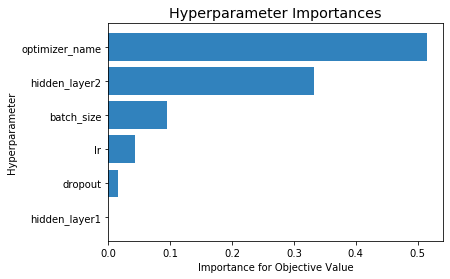

In [19]:
import matplotlib.pyplot as plt
fig = optuna.visualization.matplotlib.plot_param_importances(study)
#fig.show()
plt.savefig(name_training + '/param_importances.png', format="png",bbox_inches='tight')
plt.savefig(name_training + '/param_importances.pdf', format='pdf',bbox_inches='tight')


/tmp/ipykernel_1161016/937448550.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


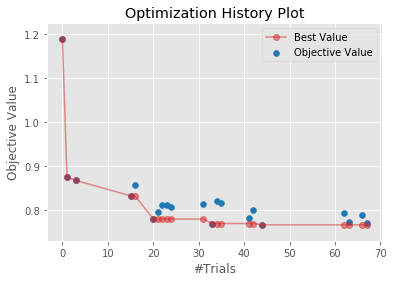

In [20]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)
#fig.show()
plt.savefig(name_training + '/optim_history.png', format="png",bbox_inches='tight')
plt.savefig(name_training + '/optim_history.pdf', format='pdf',bbox_inches='tight')

/tmp/ipykernel_1161016/2559100372.py:1: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_intermediate_values(study)
/tmp/ipykernel_1161016/2559100372.py:3: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.savefig(name_training + '/intermediate_values.png', format='png',bbox_inches='tight')
/tmp/ipykernel_1161016/2559100372.py:4: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.savefig(name_training + '/intermediate_values.pdf', format='pdf',bbox_inches='tight')
/tmp/ipykernel_1161016/2559100372.py:4: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.savefig(name_training + '/intermediate_values.pdf', for

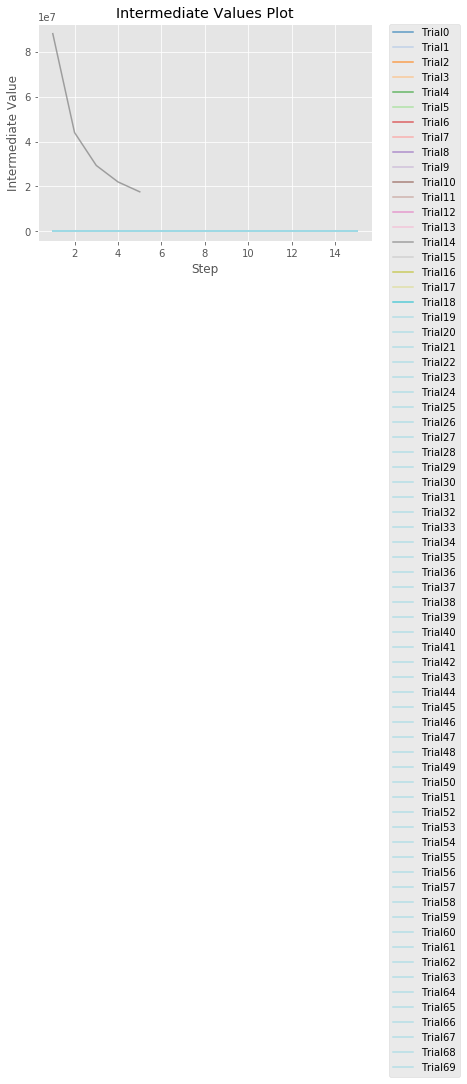

In [21]:
fig = optuna.visualization.matplotlib.plot_intermediate_values(study)
#fig.show()
plt.savefig(name_training + '/intermediate_values.png', format='png',bbox_inches='tight')
plt.savefig(name_training + '/intermediate_values.pdf', format='pdf',bbox_inches='tight')

/tmp/ipykernel_1161016/4256819052.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_slice(study)


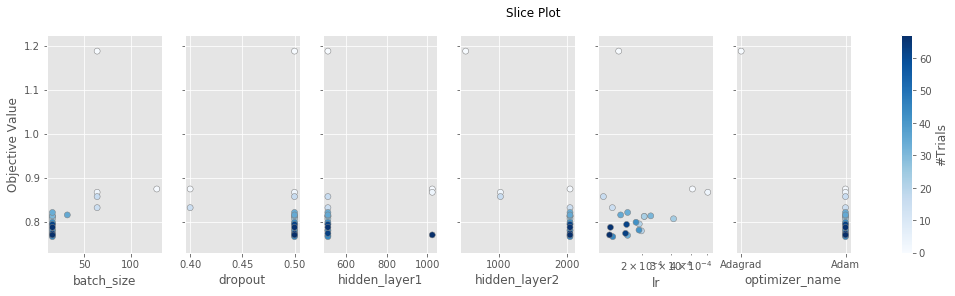

In [22]:
fig = optuna.visualization.matplotlib.plot_slice(study)
#fig.show()
plt.savefig(name_training + '/plot_slice.png', format='png',bbox_inches='tight')
plt.savefig(name_training + '/plot_slice.pdf', format='pdf',bbox_inches='tight')

/tmp/ipykernel_1161016/3816338908.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study)
[W 2022-04-24 07:35:31,002] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


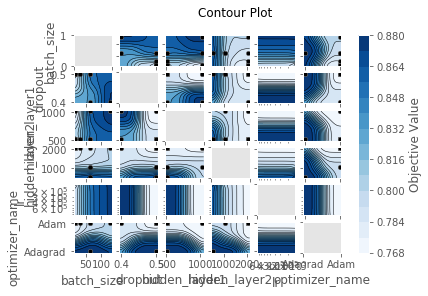

In [23]:
fig = optuna.visualization.matplotlib.plot_contour(study)
#fig.show()
plt.savefig(name_training + '/plot_contour.png', format='png',bbox_inches='tight')
plt.savefig(name_training + '/plot_contour.pdf', format='pdf',bbox_inches='tight')